In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from groq import Groq
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [241]:
# initialize groq client
def initialize_groq_client(api_key):
    client = Groq(api_key=api_key)
    print("Groq client initialized successfully")
    return client

In [243]:
# load and preprocess data
def load_and_preprocess_data(file_path):    
    df = pd.read_csv(file_path,
                 	sep=';',
                 	parse_dates={'datetime': ['Date', 'Time']},
                 	infer_datetime_format=True,
                 	na_values=['?'],
                 	low_memory=False)
    
    print("Data loaded")

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')

    print("Data Preprocessed")
    return df

In [245]:
# query 
def query_groq_llm(client, natural_language_query):
    if client is None:
        print("Groq client not available!")
        return None
    
    system_prompt = f"""You are an expert data analyst. Given a pandas DataFrame called 'df' with household power consumption data, generate ONLY the pandas code needed to answer the user's question.
    DataFrame info:
    - Index: datetime (DatetimeIndex)
    - Columns: Global_active_power, Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3
    - Global_active_power is in kilowatts
    - Data is already cleaned and preprocessed
    
    Return ONLY executable pandas code without explanations, markdown formatting, or code blocks. The code should work directly with the DataFrame 'df'."""
    
    try:
        completion = client.chat.completions.create(
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": natural_language_query}
            ],
            model="meta-llama/llama-4-scout-17b-16e-instruct", 
            temperature=0.1,
            max_tokens=500
        )
        
        code = completion.choices[0].message.content.strip()
        
        # clean the code if it has markdown 
        if code.startswith('```'):
            code = code.split('\n')[1:-1]
            code = '\n'.join(code)
        
        return code
        
    except Exception as e:
        print(f"Error querying Groq API: {e}")
        return None

In [247]:
# execution of queries
def execute_and_code(df, code, query_description):
    print(f"Query: {query_description}")
    print(f"Generated Code:\n{code}\n")
    
    try:
        df_copy = df.copy()
        
        local_vars = {'df': df_copy, 'pd': pd, 'np': np, 'plt': plt, 'sns': sns}
        exec(code, globals(), local_vars)
        
    except Exception as e:
        print(f"Error executing code: {e}")
        return None

In [249]:
def process_query(client, df, query):
    code = query_groq_llm(client, query)
    
    if code:
        result = execute_and_verify_code(df, code, query)
        return {
            "question": query,
            "code": code,
            "result": result
        }
    else:
        print(f"Failed to generate code for query: {query}")
        return None

In [250]:
def run_all_queries(client, df):
    queries = [
        "What was the average active power consumption in March 2007?",
        "What hour of the day had the highest power usage on Christmas 2006?",
        "Compare energy usage (Global_active_power) on weekdays vs weekends.",
        "Find days where energy consumption exceeded 5 kWh.",
        "Plot the energy usage trend for the first week of January 2007.",
        "Find the average voltage for each day of the first week of February 2007.",
        "What is the correlation between global active power and sub-metering values?"
    ]
    
    results = {}
    
    for i, (query) in enumerate(queries, 1):
        result = process_query(client, df, query)
        if result:
            results[f"Query_{i}"] = result
    
    return results

Groq client initialized successfully
Data loaded
Data Preprocessed

Query: What was the average active power consumption in March 2007?
Generated Code:
df_march_2007 = df[(df.index >= '2007-03-01') & (df.index < '2007-04-01')]
average_active_power = df_march_2007['Global_active_power'].mean()
print(average_active_power)

1.3186270301754073

Query: What hour of the day had the highest power usage on Christmas 2006?
Generated Code:
christmas_2006 = df[(df.index >= '2006-12-25 00:00:00') & (df.index < '2006-12-26 00:00:00')]
christmas_2006['hour'] = christmas_2006.index.hour
max_usage_hour = christmas_2006.groupby('hour')['Global_active_power'].sum().idxmax()
print(max_usage_hour)

22

Query: Compare energy usage (Global_active_power) on weekdays vs weekends.
Generated Code:
# Create a new column to indicate if the day is a weekday or weekend
df['day_type'] = df.index.dayofweek.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

# Grou

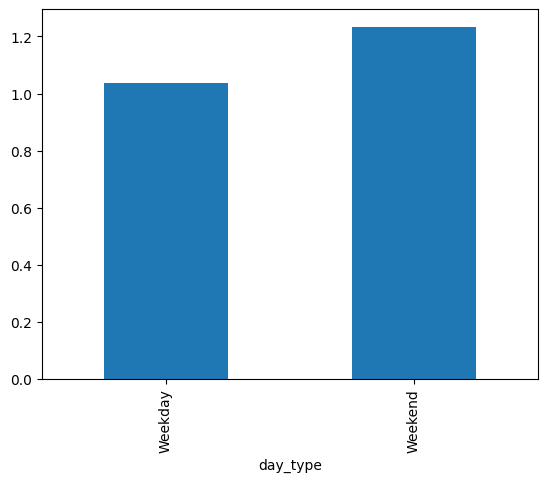

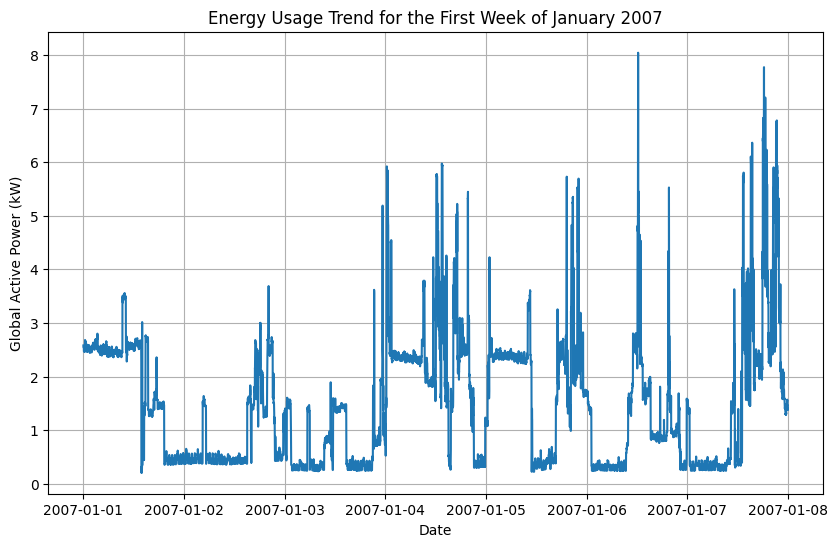


Query: Find the average voltage for each day of the first week of February 2007.
Generated Code:
df.loc[df.index.between('2007-02-01', '2007-02-07')].groupby(df.index.date).Voltage.mean()

Error executing code: 'DatetimeIndex' object has no attribute 'between'

Query: What is the correlation between global active power and sub-metering values?
Generated Code:
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()['Global_active_power']
print(correlation)

Global_active_power    1.000000
Sub_metering_1         0.484401
Sub_metering_2         0.434569
Sub_metering_3         0.638555
Name: Global_active_power, dtype: float64


In [253]:
def main():
    GROQ_API_KEY = "add the key here"

    data_file = r"C:\Users\Deena\Desktop\household_power_consumption.txt"
    if not os.path.exists(data_file):
        print("Data file not found!")
        return None
    
    try:
        client = initialize_groq_client(api_key)
        df = load_and_preprocess_data(data_file)
        
        if client is None or df is None:
            print("Failed to initialize client/df")
            return None
        
        results = run_all_queries(client, df)        
        return results
        
    except Exception as e:
        print(f"Error during analysis: {e}")
        return None

if __name__ == "__main__":
    main()